In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

###Prprocessing

In [3]:
def load_data(train_path, test_path, store_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    store = pd.read_csv(store_path)
    return train, test, store

# Load the data
train, test, store = load_data('../Data/train.csv', '../Data/test.csv', '../Data/store.csv')

# Display the first few rows of each dataset
print("Train Dataset:")
display(train.head())

print("Test Dataset:")
display(test.head())
print("Store Dataset:")
display(store.head())

C:\Users\Tesfaye\AppData\Local\Temp\ipykernel_16784\470126681.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


Train Dataset:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Test Dataset:


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Store Dataset:


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:

# Convert 'date' column to datetime
train['Date'] = pd.to_datetime(train['Date'])


In [7]:
#  Extract features from the 'date' column
train['weekday'] = train['Date'].dt.weekday  # Monday=0, Sunday=6
train['is_weekend'] = train['weekday'] >= 5  # Saturday and Sunday
train['days_to_holiday'] = train['Date'].apply(lambda x: (pd.Timestamp('2022-12-25') - x).days)  # Christmas
train['days_after_holiday'] = train['Date'].apply(lambda x: (x - pd.Timestamp('2022-12-25')).days if x >= pd.Timestamp('2022-12-25') else 0)

# Extracting beginning, mid, and end of the month
train['beginning_of_month'] = train['Date'].dt.day <= 10
train['mid_month'] = (train['Date'].dt.day > 10) & (train['Date'].dt.day <= 20)
train['end_of_month'] = train['Date'].dt.day > 20

In [9]:

#  Handle NaN values (if any)
train.fillna(0, inplace=True)  # You can choose other strategies as appropriate

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train[['Sales', 'weekday', 'days_to_holiday', 'days_after_holiday']])

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['scaled_sales', 'scaled_weekday', 'scaled_days_to_holiday', 'scaled_days_after_holiday'])

# Concatenate scaled features with original DataFrame
final_df = pd.concat([train.reset_index(drop=True), scaled_df], axis=1)

# Display the final DataFrame
print(final_df.head())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  weekday  is_weekend  days_to_holiday  days_after_holiday  \
0              1        4       False             2704                   0   
1              1        4       False             2704                   0   
2              1        4       False             2704                   0   
3              1        4       False             2704                   0   
4              1        4       False             2704                   0   

   beginning_of_month  mid_month  end_of_month  scaled_sales  

###Building models with sklearn pipelines

In [11]:
# Data preprocessing (same as before)
train['date'] = pd.to_datetime(train['Date'])
train['weekday'] = train['date'].dt.weekday
train['is_weekend'] = train['weekday'] >= 5
train['days_to_holiday'] = train['date'].apply(lambda x: (pd.Timestamp('2022-12-25') - x).days)
train['days_after_holiday'] = train['date'].apply(lambda x: (x - pd.Timestamp('2022-12-25')).days if x >= pd.Timestamp('2022-12-25') else 0)
train['beginning_of_month'] = train['date'].dt.day <= 10
train['mid_month'] = (train['date'].dt.day > 10) & (train['date'].dt.day <= 20)
train['end_of_month'] = train['date'].dt.day > 20
train.fillna(0, inplace=True)

In [13]:

# Feature selection
features = ['weekday', 'is_weekend', 'days_to_holiday', 'days_after_holiday', 
            'beginning_of_month', 'mid_month', 'end_of_month']
X = train[features]
y = train['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scaling
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

In [14]:

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 6514027.89


###loss function
Why Choose Mean Absolute Percentage Error (MAPE)?
Interpretability: MAPE expresses the error as a percentage of the actual values, making it easy to understand and communicate. For instance, a MAPE of 10% means that the predictions are off by an average of 10% from the actual sales.
Relative Error Measurement: MAPE provides insights into the accuracy of predictions relative to the magnitude of the actual values. This is particularly useful in sales data, where the scale of sales can vary significantly across different products or stores.
Sensitivity to Scale: Since MAPE normalizes the error by the actual values, it allows for a fair comparison of prediction accuracy across different scales, making it advantageous in multi-store or multi-product scenarios.
Business Relevance: Since businesses often want to minimize percentage errors, MAPE aligns well with real-world business goals.

In [15]:

# Feature selection
features = ['weekday', 'is_weekend', 'days_to_holiday', 'days_after_holiday', 
            'beginning_of_month', 'mid_month', 'end_of_month']
X = train[features]
y = train['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scaling
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])


In [16]:
from sklearn.metrics import mean_absolute_percentage_error
# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model using Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

Mean Absolute Percentage Error: 29041767163396186112.00%


###Post Prediction Analysis

In [17]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scaling
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

In [18]:

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model using Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
print(f'Mean Absolute Percentage Error: {mape:.2f}%')


Mean Absolute Percentage Error: 29041767163396186112.00%


In [19]:
# Feature Importance
model = pipeline.named_steps['model']
importances = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

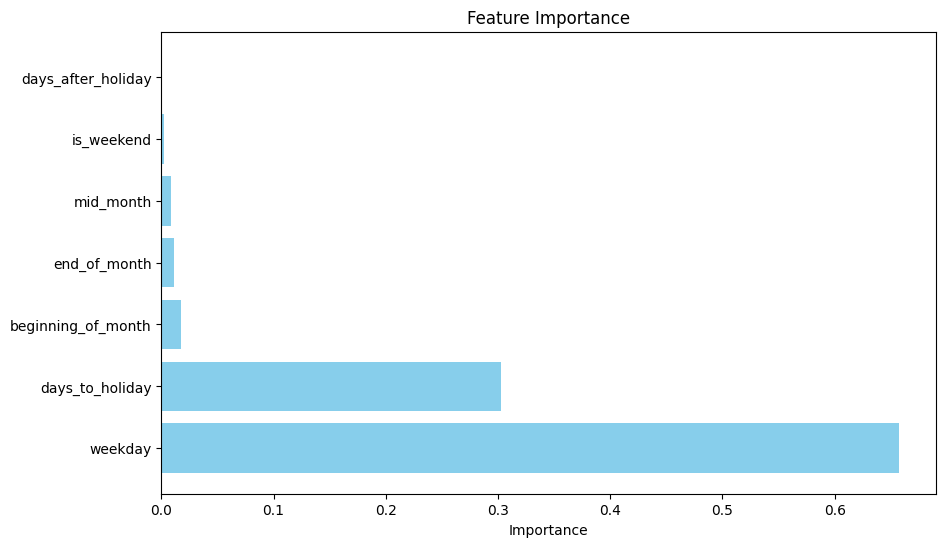

In [20]:
import matplotlib.pyplot as plt
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [21]:
# Confidence Intervals
# Get the predictions from all trees in the forest
tree_predictions = np.array([tree.predict(X_test) for tree in model.estimators_])
lower_bound = np.percentile(tree_predictions, 2.5, axis=0)
upper_bound = np.percentile(tree_predictions, 97.5, axis=0)

# Create a DataFrame to display predictions and confidence intervals
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
})

print(predictions_df.head())

c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without f

        Actual     Predicted  Lower Bound  Upper Bound
76435        0    185.773228    57.893486   227.057212
923026    5548   8324.389070  5042.832911  7055.187755
731180    7467   5323.983896    66.244502   239.350270
790350    3360   5194.139190  5042.832911  7055.187755
252134   11414  12987.321210    77.956355  7324.640738


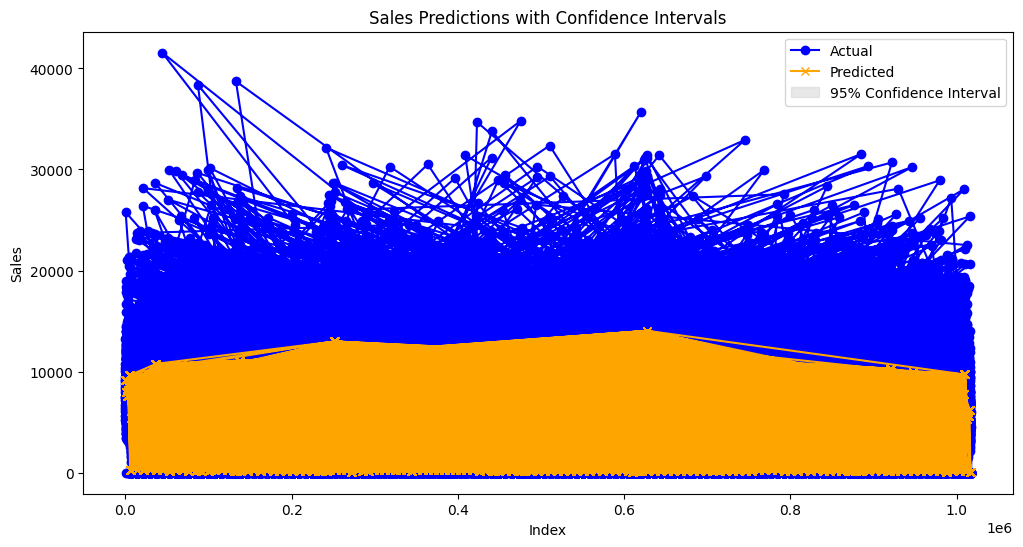

In [22]:

# Plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange', marker='x')
plt.fill_between(y_test.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='95% Confidence Interval')
plt.title('Sales Predictions with Confidence Intervals')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()

###serialize models

In [23]:
import joblib
import datetime
# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scaling
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

In [24]:

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model using Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

Mean Absolute Percentage Error: 29041767163396186112.00%


In [25]:

# Serialize the model with a timestamp
timestamp = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
model_filename = f"sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f'Model saved as: {model_filename}')

Model saved as: sales_model_09-25-2024-11-18-40.pkl


###building model with deep learning

In [36]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

ModuleNotFoundError: No module named 'statsmodels'

In [31]:
 
# For demonstration, we will create a sample dataset
np.random.seed(42)
dates = pd.date_range(start='2015-01-01', periods=100, freq='D')
sales = np.random.randint(100, 1000, size=len(dates))
store = pd.DataFrame({'date': dates, 'sales': sales})

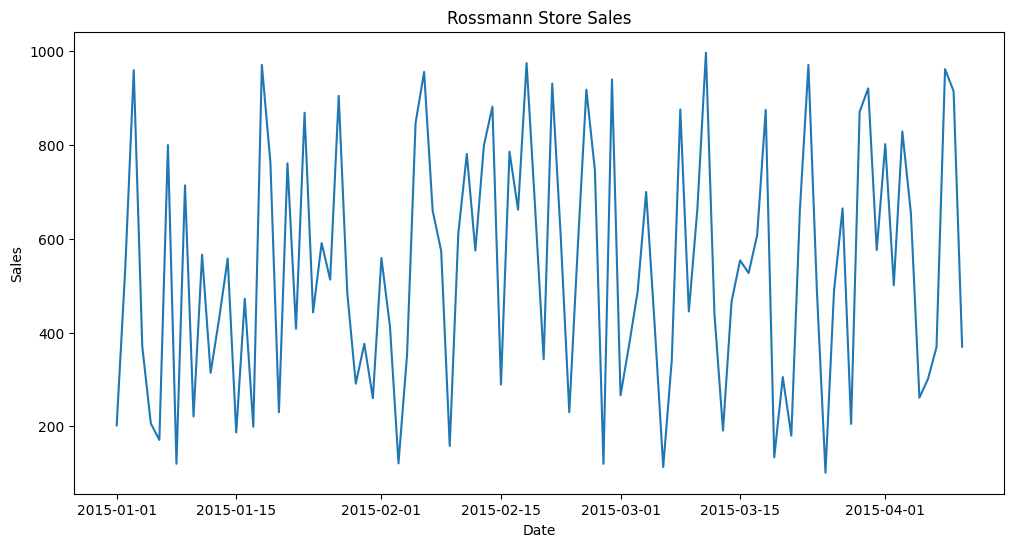

In [32]:
# Set the date as the index
store.set_index('date', inplace=True)

# Visualize the dataset
plt.figure(figsize=(12, 6))
plt.plot(store['sales'])
plt.title('Rossmann Store Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [34]:

# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

check_stationarity(store['sales'])

# Differencing the data to make it stationary if required
store['sales_diff'] = store['sales'].diff().dropna()
check_stationarity(store['sales_diff'].dropna())

NameError: name 'adfuller' is not defined

In [ ]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(df['sales_diff'].dropna(), lags=20)
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['sales_diff'].dropna(), lags=20)
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:

# Create supervised learning data
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df['sales'].values.reshape(-1, 1))


In [ ]:
# Create the dataset with a sliding window
time_step = 10
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions
predicted_sales = model.predict(X_test)
predicted_sales = scaler.inverse_transform(predicted_sales)

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + time_step + 1:], predicted_sales, label='Predicted Sales', color='orange')
plt.plot(df.index, df['sales'], label='Actual Sales', color='blue')
plt.title('Sales Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()